In [ ]:
#Importación de librerías necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split,RandomizedSearchCV, learning_curve, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.impute import IterativeImputer


1. Recoger datos

In [4]:
train = pd.read_csv("rendimiento_estudiantes_train.csv") #se analizarán los datos de este df
test = pd.read_csv("rendimiento_estudiantes_test_vacio.csv") #se utilizará para el predict final

2. Preproceso y limpieza

In [5]:
#se hacen análisis previos para ver la forma de los datos que se van a manejar
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   escuela        835 non-null    object 
 1   sexo           835 non-null    object 
 2   edad           835 non-null    int64  
 3   entorno        835 non-null    object 
 4   TamFam         835 non-null    object 
 5   EstPadres      835 non-null    object 
 6   Medu           783 non-null    float64
 7   Pedu           731 non-null    float64
 8   Mtrab          835 non-null    object 
 9   Ptrab          835 non-null    object 
 10  razon          835 non-null    object 
 11  tutor          835 non-null    object 
 12  TiempoViaje    835 non-null    int64  
 13  TiempoEstudio  819 non-null    float64
 14  suspensos      835 non-null    int64  
 15  apoyo          835 non-null    object 
 16  ApFam          835 non-null    object 
 17  academia       835 non-null    object 
 18  extras    

In [6]:
train.describe()

,edad,Medu,Pedu,TiempoViaje,TiempoEstudio,suspensos,RelFam,TiempoLib,SalAm,AlcSem,AlcFin,salud,faltas,T1,T2,T3
count,835.000000,783.000000,731.000000,835.000000,819.000000,835.000000,818.000000,835.000000,835.000000,815.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000
mean,16.755689,2.628352,2.410397,1.520958,1.957265,0.283832,3.904645,3.201198,3.132934,1.505521,2.276647,3.553293,9.682235,11.204790,11.238323,11.326946
std,1.244730,1.115372,1.114586,0.711656,0.829988,0.680079,0.950786,1.030819,1.147536,0.920504,1.274682,1.425352,33.985657,3.066016,3.381352,3.993061
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,7.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,246.036983,19.000000,19.000000,20.000000


In [7]:
print(train.isnull().sum())

escuela            0
sexo               0
edad               0
entorno            0
TamFam             0
EstPadres          0
Medu              52
Pedu             104
Mtrab              0
Ptrab              0
razon              0
tutor              0
TiempoViaje        0
TiempoEstudio     16
suspensos          0
apoyo              0
ApFam              0
academia           0
extras             0
enfermeria         0
EstSup             0
internet           0
pareja             0
RelFam            17
TiempoLib          0
SalAm              0
AlcSem            20
AlcFin             0
salud              0
faltas             0
asignatura         0
T1                 0
T2                 0
T3                 0
dtype: int64


In [8]:
#Tras hacer un análisis y preprocesamiento de los datos se ve que hay datos faltantes. Al ser un dataset no muy grande se clasifican estos datos nulos como informativos por lo que no se 
# #eliminan y se sustituyen por la media. En este caso se emplea la media ya que es la medida que menos altera el conjunto total de los datos. Antes de hacer este paso, se analiza la 
# #distribución de T3 (variable que se va a predecir en un futuro muy cercano) y los outliers (datos atípicos).

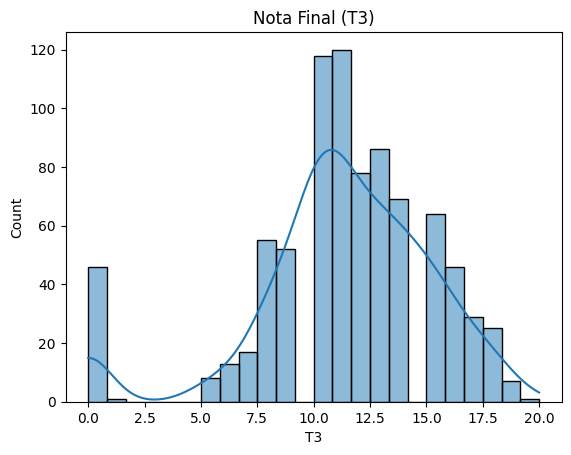

In [9]:
sns.histplot(train['T3'], kde=True)
plt.title('Nota Final (T3)')
plt.show()
#Se plotea T3 (nota final) para ver su distribución general (normal, sesgada, bimodal...), para detectar posibles valores atípicos/extremos y para
#entender si estamos trabajando con un problema de regresión (nota continua) o si podríamos tratarlo como clasificación (si se quisiesen categorizar los resultados)
#como T3 es continua, no se considera un problema clásico de clasificación con clases balanceadas/desbalanceadas y por ello aplicar down-sampling/ up-sampling no tiene sentido.

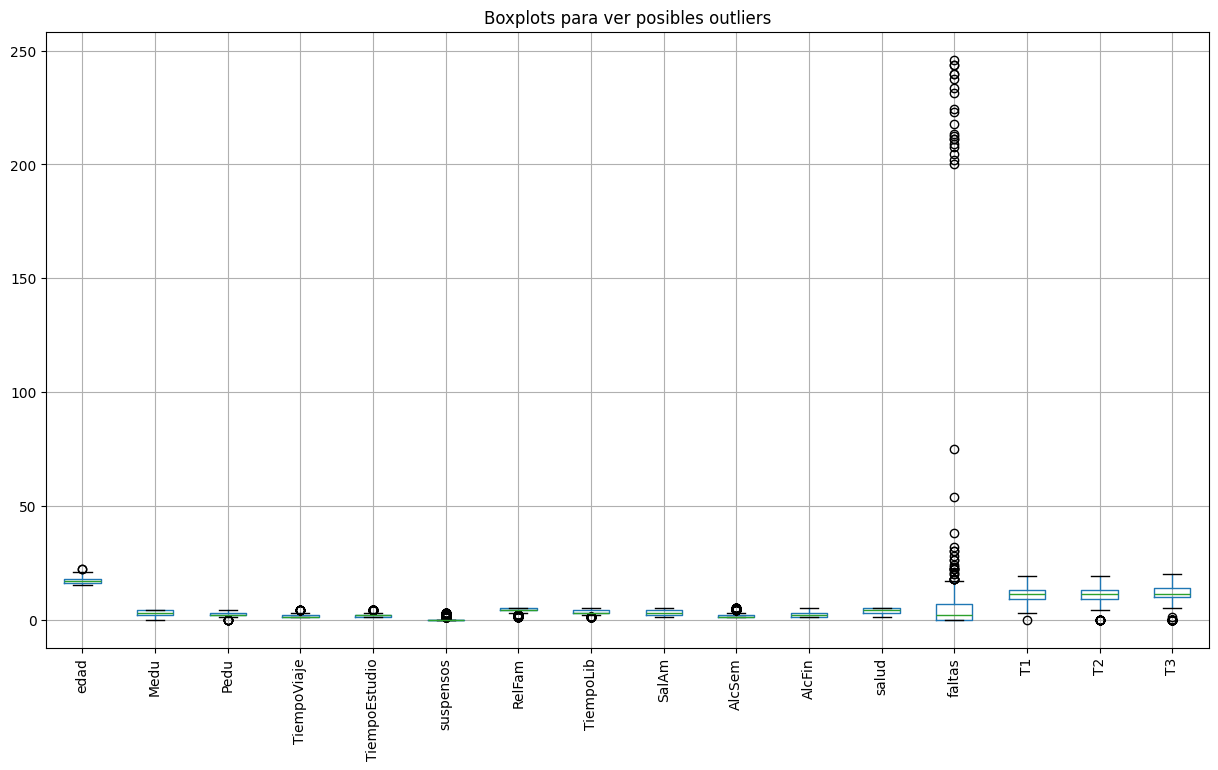

In [10]:
#análisis de outliers en las variables numéricas de forma visual con boxplots
variables_numericas = train.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(15, 8))
train[variables_numericas].boxplot(rot=90)
plt.title("Boxplots para ver posibles outliers")
plt.show()

In [11]:
#como se puede apreciar hay muchos datos atípicos en faltas, como posteriormente se va a aplicar el modelo RandomForest (robusto ante outliers) no se tratan de forma
#especial estos datos. Si se quisiesen tratar estos datos se podría hacer una eliminación de estos datos atípicos mediante el rango intercuartílico IQR.

In [ ]:
#FInalmente se imputan los datos faltantes con IterativeImputer ya que utiliza modelos de regresión para predecir iterativamente los valores faltantes de cada columna
#  numérica basándose en los valores presentes y en las relaciones entre las demás variables del dataset.
imputer = IterativeImputer(random_state=42)
num_cols = train.select_dtypes(include=[np.number]).columns
train[num_cols] = imputer.fit_transform(train[num_cols])

In [13]:
#se comprueba que se hayan sustituido correctamente los datos faltantes
print(train.isnull().sum())

escuela          0
sexo             0
edad             0
entorno          0
TamFam           0
EstPadres        0
Medu             0
Pedu             0
Mtrab            0
Ptrab            0
razon            0
tutor            0
TiempoViaje      0
TiempoEstudio    0
suspensos        0
apoyo            0
ApFam            0
academia         0
extras           0
enfermeria       0
EstSup           0
internet         0
pareja           0
RelFam           0
TiempoLib        0
SalAm            0
AlcSem           0
AlcFin           0
salud            0
faltas           0
asignatura       0
T1               0
T2               0
T3               0
dtype: int64


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   escuela        835 non-null    object 
 1   sexo           835 non-null    object 
 2   edad           835 non-null    float64
 3   entorno        835 non-null    object 
 4   TamFam         835 non-null    object 
 5   EstPadres      835 non-null    object 
 6   Medu           835 non-null    float64
 7   Pedu           835 non-null    float64
 8   Mtrab          835 non-null    object 
 9   Ptrab          835 non-null    object 
 10  razon          835 non-null    object 
 11  tutor          835 non-null    object 
 12  TiempoViaje    835 non-null    float64
 13  TiempoEstudio  835 non-null    float64
 14  suspensos      835 non-null    float64
 15  apoyo          835 non-null    object 
 16  ApFam          835 non-null    object 
 17  academia       835 non-null    object 
 18  extras    

In [15]:
train.describe()

,edad,Medu,Pedu,TiempoViaje,TiempoEstudio,suspensos,RelFam,TiempoLib,SalAm,AlcSem,AlcFin,salud,faltas,T1,T2,T3
count,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000
mean,16.755689,2.630861,2.422078,1.520958,1.957071,0.283832,3.904582,3.201198,3.132934,1.498807,2.276647,3.553293,9.682235,11.204790,11.238323,11.326946
std,1.244730,1.097796,1.070250,0.711656,0.822431,0.680079,0.941300,1.030819,1.147536,0.911198,1.274682,1.425352,33.985657,3.066016,3.381352,3.993061
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.850356,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,3.825347,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,7.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,246.036983,19.000000,19.000000,20.000000


In [16]:
#se codifican las variables categóricas con one-hot-encoding para conseguir un dataset uniforme en cuanto a tipo de datos. Con one hot encoding, se consigue mostrar esa variable
# de forma binaria con una nueva columna. Se omite para este proceso T3 ya que es la variable a predecir.
train_encoded = pd.get_dummies(train.drop(columns=['T3']), drop_first=True)
y = train['T3']
X = train_encoded.copy()

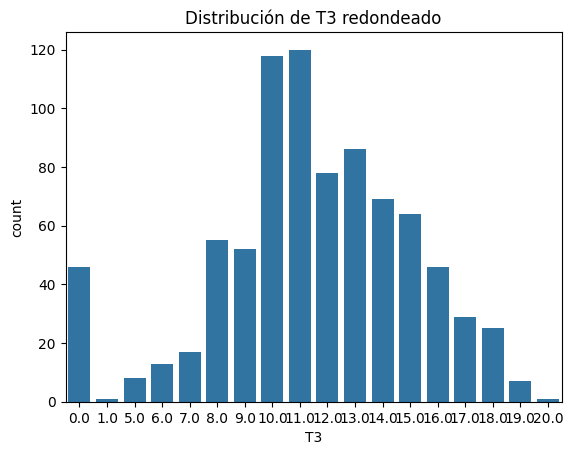

In [17]:
#Se verifica como de balanceadas están las clases (se ha redondeando la nota a enteros para ser más fácil de visualizar)
sns.countplot(x=np.round(y))
plt.title("Distribución de T3 redondeado")
plt.show()

In [18]:
#se puede apreciar una distribución prácticamente normal(gaussiana) siendo el aprobado lo más común. Se aprecia también un alto número de 0s, dato algo sorprendente.(quizás son no presentados)
# No se balancean estos datos ya que son parte del dataset y cambiarlos modificaría las predicciones y por tanto, la fiabilidad del modelo, pero es útil saber como son los datos.

In [19]:
#Comentario adicional: Al emplear RandomForest, no se estandarizan los datos ya que no es necesario dicho paso, por tanto, en este momento se omite la estandarización de los datos. 
#Más adelante en PCA si se estandarizarán.

3. y 4. Separación de datos para modelos y validaciones, entrenar modelo y adptar parámetros

In [20]:
#modelo i)
X_train_i, X_val_i, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'SVR': SVR()
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))
r2_scorer = make_scorer(r2_score)

results = {}

for name, model in models.items():
    r2 = cross_val_score(model, X, y, cv=kf, scoring='r2')
    rmse = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    results[name] = {
        'R2_promedio': np.mean(r2),
        'RMSE_promedio': np.mean(rmse)
    }

for name, scores in results.items():
    print(f"Modelo: {name}")
    print(f"  R2 promedio: {scores['R2_promedio']:.4f}")
    print(f"  RMSE promedio: {scores['RMSE_promedio']:.4f}")
    print()

Modelo: RandomForest
  R2 promedio: 0.8548
  RMSE promedio: 1.4953

Modelo: GradientBoosting
  R2 promedio: 0.8584
  RMSE promedio: 1.4802

Modelo: LinearRegression
  R2 promedio: 0.8293
  RMSE promedio: 1.6395

Modelo: DecisionTree
  R2 promedio: 0.7133
  RMSE promedio: 2.1014

Modelo: SVR
  R2 promedio: 0.7791
  RMSE promedio: 1.8675



In [22]:
#Aunque el mejor desempeño lo tiene Gradient Boosting, Random Forest también muestra buenos resultados (R2=0.8549, RMSE=1.4943), por lo tanto se escoge Random Forest
#porque es menos propenso al sobreajuste por su estructura de ensamblado de árboles independientes y típicamente requiere menos ajuste fino de hiperparámetros, 
# lo que lo hace más robusto ante diferentes tipos de datos y más fácil de usar si se dispone de poco tiempo para ajuste. Además, Random Forest suele ser más rápido
#  de entrenar y menos sensible a los cambios en los datos o a la presencia de ruido, mientras que Gradient Boosting, aunque a veces logra mejores resultados, puede
#  ser más vulnerable a sobreajuste y requiere un ajuste cuidadoso para evitarlo. Si las diferencias de desempeño entre ambos son pequeñas, Random Forest se convierte
#  en la opción preferible por su mayor estabilidad, simplicidad y rapidez.

In [23]:
modelo_i = RandomForestRegressor(random_state=42)
modelo_i.fit(X_train_i, y_train)
pred_i = modelo_i.predict(X_val_i)

In [24]:
print("Modelo i (con T1 y T2)")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, pred_i))}")
print(f"R2: {r2_score(y_val, pred_i)}")

Modelo i (con T1 y T2)
RMSE: 1.354421457682187
R2: 0.8898651012201527


In [25]:
#El modelo i, que incluye las notas de los dos primeros trimestres (T1 y T2) como predictores, ha obtenido un RMSE de 1.36 y un coeficiente de determinación R² de 0.889. 
# Estos resultados indican que el modelo comete un error promedio de apenas 1.36 puntos sobre los 20 posibles al predecir la nota final (T3), lo cual es bastante preciso. 
# Además, el modelo es capaz de explicar el 88.9% de la variabilidad en el rendimiento final de los estudiantes, lo que puede explicar que según los estudiantes hayan rendido 
# en los dos primeros trimestres vayan a rendir de cara a la nota final (T3). En resumen, estos resultados reflejan que este primer modelo es un modelo sólido y confiable para 
# este tipo de predicción.

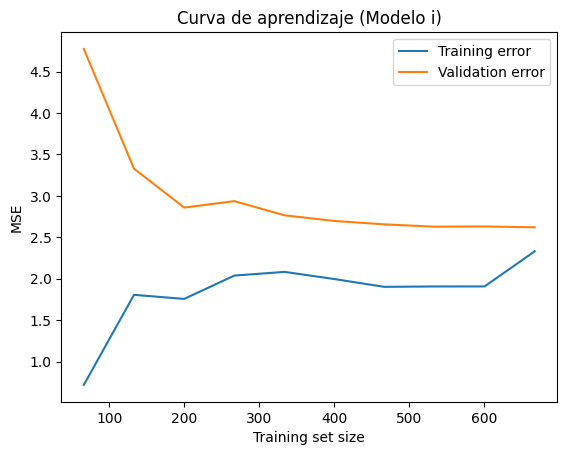

In [26]:
train_sizes, train_scores, test_scores = learning_curve(
    Ridge(), X, y, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Training error')
plt.plot(train_sizes, test_mean, label='Validation error')
plt.xlabel("Training set size")
plt.ylabel("MSE")
plt.title("Curva de aprendizaje (Modelo i)")
plt.legend()
plt.show()


In [27]:
#como se aprecia el modelo puede tener algo de overfitting al principio, aún así acaba con valores de error muy parecidos entre training y validation

In [28]:
#modelo ii)
X_sin_T1T2 = X.drop(columns=['T1', 'T2'], errors='ignore')
X_train_ii, X_val_ii = train_test_split(X_sin_T1T2, test_size=0.2, random_state=42)

In [29]:
modelo_ii = RandomForestRegressor(random_state=42)
modelo_ii.fit(X_train_ii, y_train)
pred_ii = modelo_ii.predict(X_val_ii)

In [30]:
print("\nModelo ii (sin T1 y T2)")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, pred_ii))}")
print(f"R2: {r2_score(y_val, pred_ii)}")


Modelo ii (sin T1 y T2)
RMSE: 3.2047277949181514
R2: 0.38340556603204956


In [31]:
#El modelo ii, que elimina las notas de los trimestres anteriores (T1 y T2) del dataset, obtiene un RMSE de 3.21 y un coeficiente de determinación R² de 0.382. 
# Esto significa que el modelo presenta un error promedio de más de 3 puntos sobre los 20 posibles al predecir la nota final (T3), lo que representa una pérdida 
# considerable de precisión respecto al modelo anterior(modelo i). Además, solo logra explicar el 38.2% de la variabilidad en el rendimiento final de los estudiantes, lo que indica
#  que las variables no académicas, aunque son algo influyentes, no son suficientes por sí solas para predecir de forma fiable las calificaciones finales. 
# En resumen, este modelo es bastante menos preciso que el modelo i, lo que destaca la importancia de disponer de información previa sobre el rendimiento académico
#  del estudiante para hacer predicciones más precisas y acertadas sobre sus calificaciones finales.

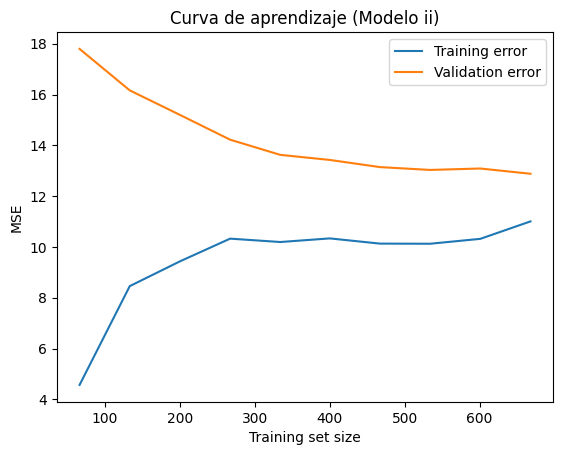

In [32]:
train_sizes, train_scores, test_scores = learning_curve(
    Ridge(), X_sin_T1T2, y, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Training error')
plt.plot(train_sizes, test_mean, label='Validation error')
plt.xlabel("Training set size")
plt.ylabel("MSE")
plt.title("Curva de aprendizaje (Modelo ii)")
plt.legend()
plt.show()


In [33]:
#esta gráfica tiene el mismo análisis que el nmodelo i en cuanto a overfitting pero se puede apreciar por la escala de los ejes que estamos hablando de errores bastante altos
#comparados con el primer modelo, esto está causado por haber quitado T1 y T2, esto quedará demostrado más adelante.

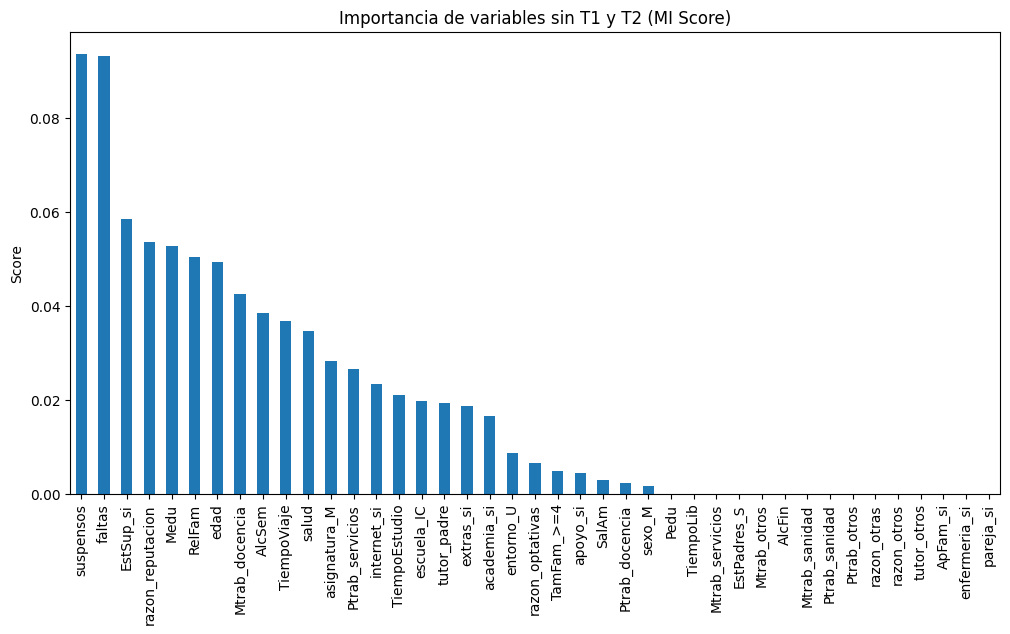

In [34]:
#Ya que el modelo ii no usa T1 ni T2, se muestran las variables que explican mejor T3 sin tener en cuenta T1/T2.

X_wo_notas = X.drop(columns=["T1", "T2"])
mi_scores = mutual_info_regression(X_wo_notas, y)
mi_series = pd.Series(mi_scores, index=X_wo_notas.columns).sort_values(ascending=False)

mi_series.plot(kind='bar', figsize=(12,6), title="Importancia de variables sin T1 y T2 (MI Score)")
plt.ylabel("Score")
plt.show()

#se ve que las variables más importantes son suspensos y faltas por mucha diferencia.

In [35]:
#Ahora se muestran gráficas comparativas para poder visualizar toda esta explicación teórica

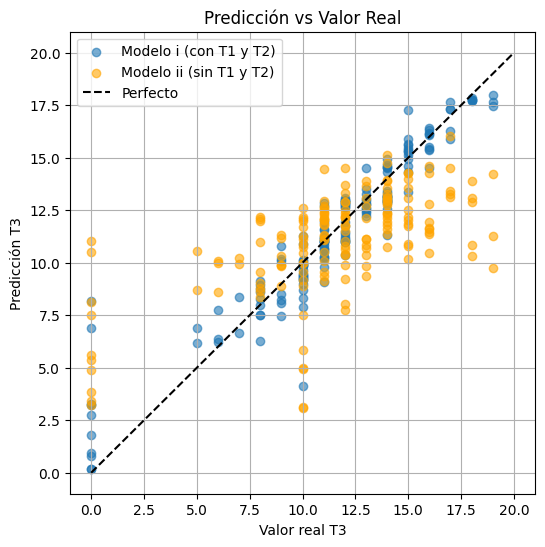

In [36]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, pred_i, alpha=0.6, label='Modelo i (con T1 y T2)')
plt.scatter(y_val, pred_ii, alpha=0.6, label='Modelo ii (sin T1 y T2)', color='orange')
plt.plot([0, 20], [0, 20], 'k--', label='Perfecto')
plt.xlabel('Valor real T3')
plt.ylabel('Predicción T3')
plt.title('Predicción vs Valor Real')
plt.legend()
plt.grid(True)
plt.show()
#se puede apreciar que los puntos del primer modelo se ajustan más al modelo perfecto, mientras que los del segundo modelo se encuentran más dispersos y más alejados del modelo perfecto, lo 
#que indica que es peor modelo que el primero.

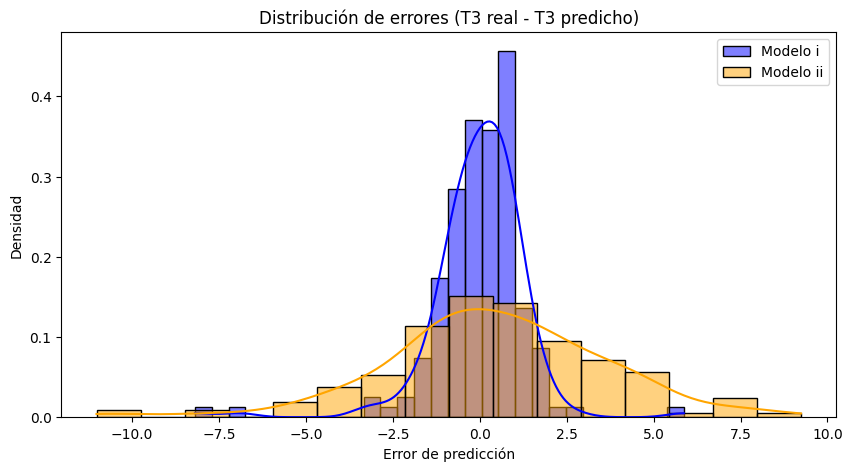

In [37]:
errors_i = y_val - pred_i
errors_ii = y_val - pred_ii

plt.figure(figsize=(10, 5))
sns.histplot(errors_i, kde=True, color='blue', label='Modelo i', stat='density')
sns.histplot(errors_ii, kde=True, color='orange', label='Modelo ii', stat='density')
plt.title('Distribución de errores (T3 real - T3 predicho)')
plt.xlabel('Error de predicción')
plt.ylabel('Densidad')
plt.legend()
plt.show()
#se puede apreciar que los errores del modelo i) se encuentran más concentrados en el 0, mientras que el segundo modelo está mas esparcido (mayor varianza). Esto refleja que el 
# primer modelo comete errores más pequeños y consistentes mientras que el segundo modelo se equivoca más y con mayor variabilidad, es decir, es menos confiable.

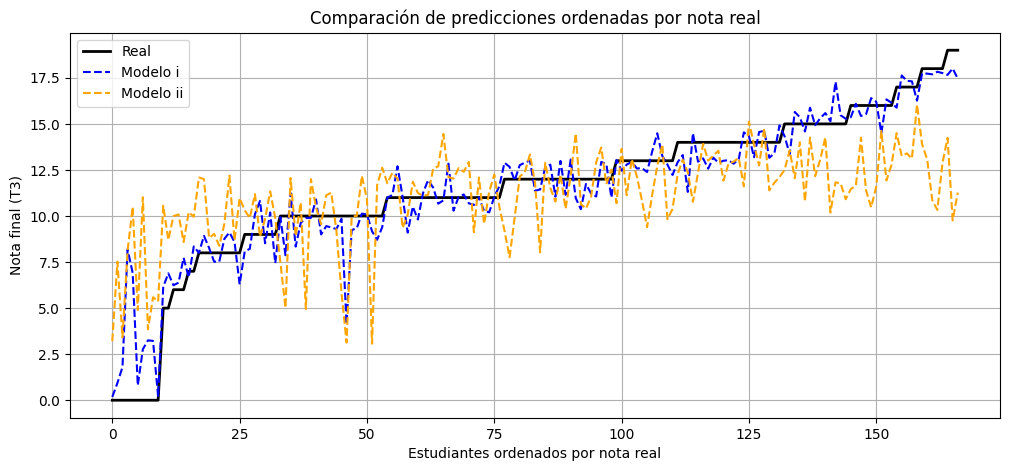

In [38]:
df_resultados = pd.DataFrame({
    'T3_real': y_val.values,
    'Modelo_i': pred_i,
    'Modelo_ii': pred_ii
}).sort_values('T3_real').reset_index(drop=True)

plt.figure(figsize=(12, 5))
plt.plot(df_resultados['T3_real'], label='Real', linewidth=2, color='black')
plt.plot(df_resultados['Modelo_i'], label='Modelo i', linestyle='--', color='blue')
plt.plot(df_resultados['Modelo_ii'], label='Modelo ii', linestyle='--', color='orange')
plt.title('Comparación de predicciones ordenadas por nota real')
plt.xlabel('Estudiantes ordenados por nota real')
plt.ylabel('Nota final (T3)')
plt.legend()
plt.grid(True)
plt.show()
#como se puede apreciar de forma evidente el primer modelo se ajusta mejor a las predicciones incluso en los extremos mientras que el segundo modelo es más aplanado
#y por tanto tiende a subestimar o sobreestimar ya que aplana los resultados hacia el centro.

In [39]:
#Ahora para poder mejorar el modelo ii se hace cross validation para Random Forest ya que dicho modelo no admite descenso gradiente. Para ello, se hace cv para los parámetros elegidos,
#en este caso: n_estimators, max_depth, learning_rate,subsample, min_samples_split y min_samples_leaf. Para este cross-validation se ha empleado RandomizedSearchCV que hace combinaciones de los hiperparámetros y elige los
#que minimizan el error. Se emplea este tipo de búsqueda aleatoria ya que emplea un rango continuo en vez de discreto, lo que hace que se adapten mejor los parámetros y sobre todo de forma más precisa

In [40]:
#modelo ii) nuevo
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

gb_random = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

gb_random.fit(X_train_ii, y_train)
print("Mejores parámetros Modelo ii (RandomizedSearchCV):", gb_random.best_params_)

modelo_ii_opt = gb_random.best_estimator_
pred_ii_opt = modelo_ii_opt.predict(X_val_ii)

Mejores parámetros Modelo ii (RandomizedSearchCV): {'learning_rate': np.float64(0.01469092202235818), 'max_depth': 11, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 235, 'subsample': np.float64(0.602208846849441)}


In [41]:
rmse_optimizado = np.sqrt(mean_squared_error(y_val, pred_ii_opt))
r2_optimizado = r2_score(y_val, pred_ii_opt)

print("\nModelo ii con CV (sin T1 y T2)")
print(f"RMSE: {rmse_optimizado}")
print(f"R2: {r2_optimizado}")


Modelo ii con CV (sin T1 y T2)
RMSE: 3.0194841466859397
R2: 0.4526277032419417


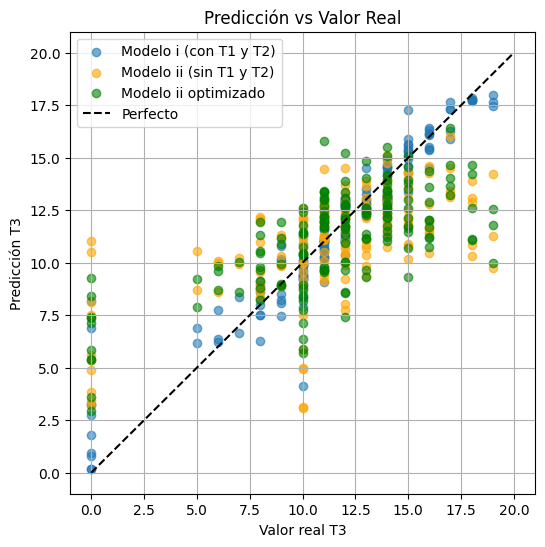

In [42]:
#como se puede apreciar han mejorado los anteriores cálculos de RMSE y R^2 con este nuevo modelo aunque no se acerca ni de lejos a las predicciones obtenidas por el modelo i.
#Para poder verlo de forma clara, se hacen de nuevo las gráficas comparativas pero ahora con los 3 modelos (modelo i, modelo ii, modelo ii optimizado)
plt.figure(figsize=(6, 6))
plt.scatter(y_val, pred_i, alpha=0.6, label='Modelo i (con T1 y T2)')
plt.scatter(y_val, pred_ii, alpha=0.6, label='Modelo ii (sin T1 y T2)', color='orange')
plt.scatter(y_val, pred_ii_opt, alpha=0.6, label='Modelo ii optimizado', color='green')  # Nueva predicción
plt.plot([0, 20], [0, 20], 'k--', label='Perfecto')
plt.xlabel('Valor real T3')
plt.ylabel('Predicción T3')
plt.title('Predicción vs Valor Real')
plt.legend()
plt.grid(True)
plt.show()
#como se puede ver en la gráfica, el nuevo modelo optimizado se ajusta algo más al modelo perfecto sin ser ni parecido al modelo i que se ajusta bastante bien al modelo perfecto.
#Muestra algo menos de dispersión que el modelo ii sin optimizar pero aún asi se encuentra bastante lejos de la línea diagonal negra del modelo perfecto.

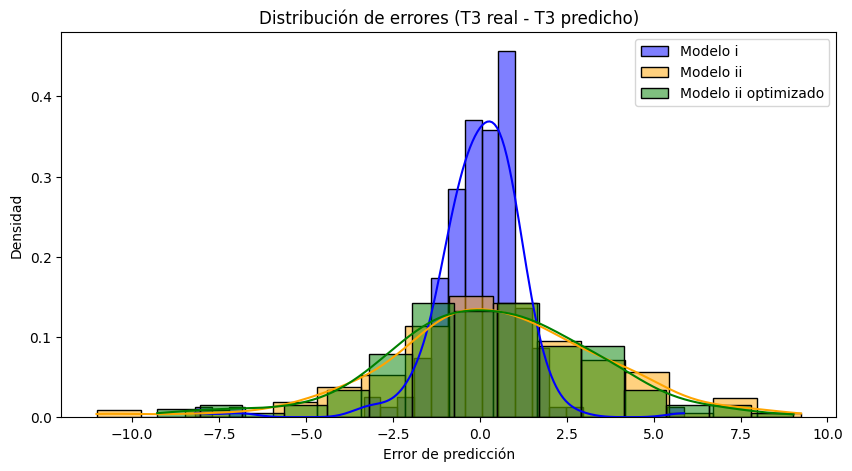

In [43]:
errors_ii_opt = y_val - pred_ii_opt

plt.figure(figsize=(10, 5))
sns.histplot(errors_i, kde=True, color='blue', label='Modelo i', stat='density')
sns.histplot(errors_ii, kde=True, color='orange', label='Modelo ii', stat='density')
sns.histplot(errors_ii_opt, kde=True, color='green', label='Modelo ii optimizado', stat='density')
plt.title('Distribución de errores (T3 real - T3 predicho)')
plt.xlabel('Error de predicción')
plt.ylabel('Densidad')
plt.legend()
plt.show()
#se vuelve a ver lo mostrado en el gráfico anterior. Se trata de un modelo ii mejorado pero sin llegar a acercarse a la concentración en el 0 del modelo i.
#Con la línea continua que define el histograma se ve como es algo más puntiaguda/concentrada en el 0 que el modelo ii pero sin llegar a ser como el modelo i (azul)

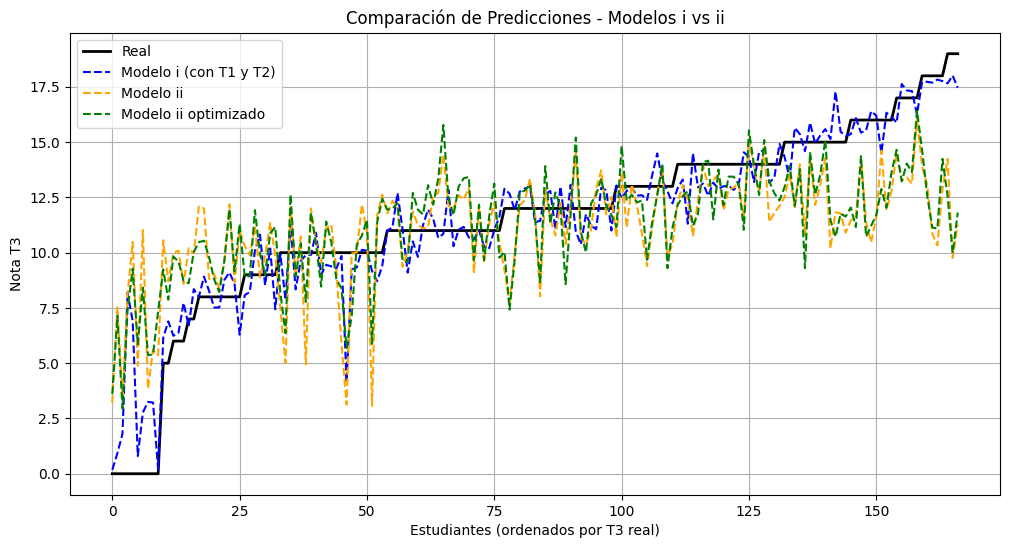

In [44]:
df_comparacion = pd.DataFrame({
    'Real': y_val.reset_index(drop=True),
    'Modelo_i': pred_i,
    'Modelo_ii': pred_ii,
    'Modelo_ii_optimizado': pred_ii_opt
}).sort_values(by='Real').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(df_comparacion['Real'], label='Real', color='black', linewidth=2)
plt.plot(df_comparacion['Modelo_i'], label='Modelo i (con T1 y T2)', linestyle='--', color='blue')
plt.plot(df_comparacion['Modelo_ii'], label='Modelo ii', linestyle='--', color='orange')
plt.plot(df_comparacion['Modelo_ii_optimizado'], label='Modelo ii optimizado', linestyle='--', color='green')
plt.title('Comparación de Predicciones - Modelos i vs ii')
plt.xlabel('Estudiantes (ordenados por T3 real)')
plt.ylabel('Nota T3')
plt.legend()
plt.grid(True)
plt.show()
#como sen ha podido ver en las gráficas anteriores, el modelo ii optimizado es un modelo que se encuentra entre medias de modelo i y modelo ii en cuanto a nivel de predicciones.
# En esta última gráfioca se ve como el nuevo modelo sigue sin ser tan preciso como lo es el modelo i pero no es tan impreciso ni lejano a la predicción real como sí que lo era el modelo ii.
#En este gráfico se ve como el nuevo modelo predice peor en los extremos y tiene muchos picos alejados del modelo real en el centro.

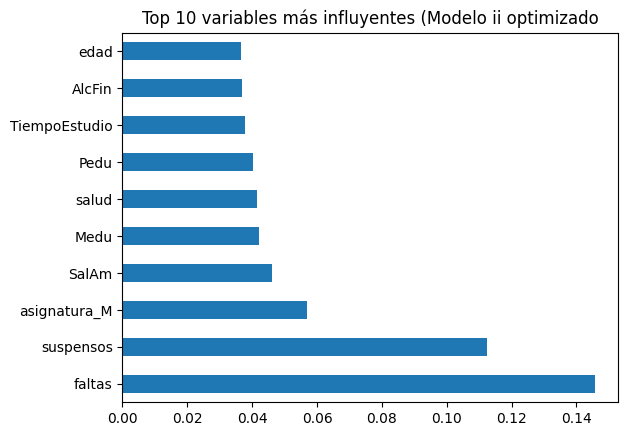

In [45]:
#Ahora se van a analizar las variables más inmportantes como en el modelo ii sin optimizar.
importancias = pd.Series(modelo_ii_opt.feature_importances_, index=train_encoded.drop(columns=['T1', 'T2'], errors='ignore').columns)
importancias.nlargest(10).plot(kind='barh')
plt.title('Top 10 variables más influyentes (Modelo ii optimizado')
plt.show()

In [46]:
#como se aprecia en la gráfica los features más influyentes son las faltas (numero de días que el alumno falta a clase) y los suspensos (numero de suspensos en curso anterior), al igual que
#en el modelo ii sin optimizar pero esta vez siendo faltas más importante que suspensos.
#Para proponer soluciones e ideas sobre los factores que más influyan se explora algo más el dataset con gráficas extra.

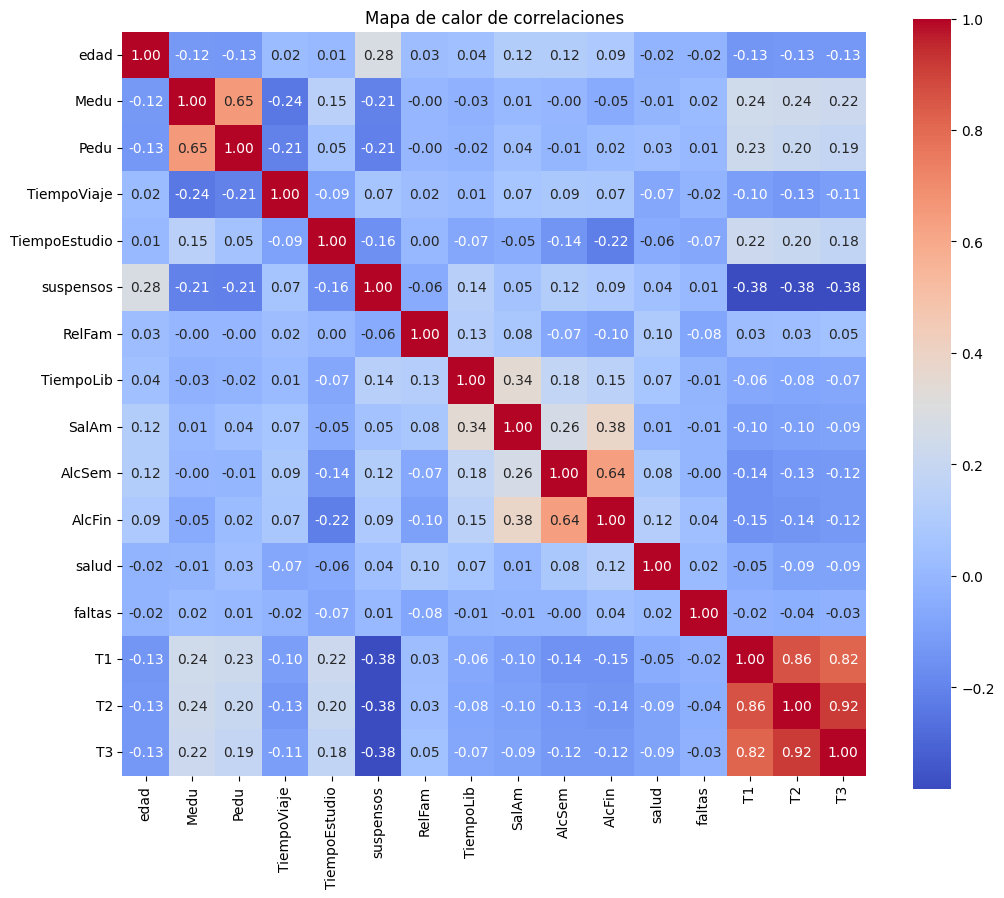

In [47]:
#matriz de correlaciones
plt.figure(figsize=(12, 10))
corr_matrix = train[variables_numericas].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Mapa de calor de correlaciones")
plt.show()
#como se puede ver en la matriz de correlaciones, las que más relacion tienen son T1, T2 y T3, lo que ya se sabía desde el principio del proyecto. Como se sabe que la
#correlación no implica causalidad, se explora exactamente la relación con T3 de las supuestas features más importantes(faltas, suspensos) mediante violinplots.

C:\Users\alvar\AppData\Local\Temp\ipykernel_3872\1344556029.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=train, x='Grupo_Faltas', y='T3', inner='box', palette='Blues')


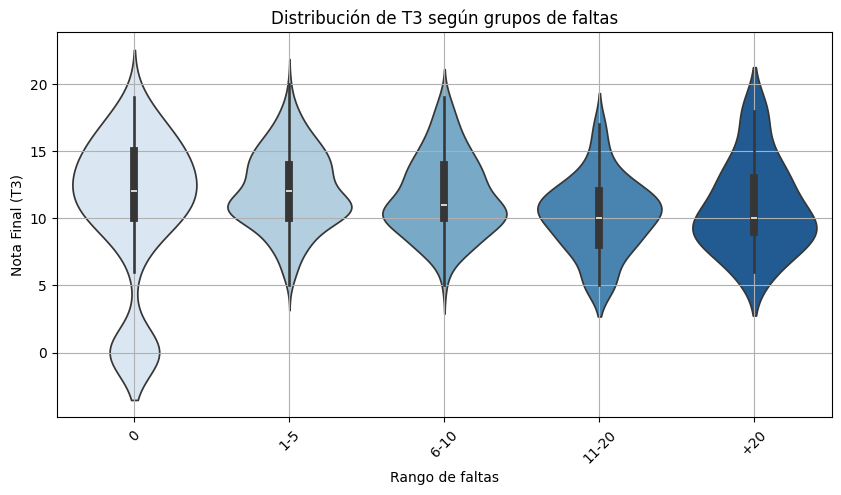

C:\Users\alvar\AppData\Local\Temp\ipykernel_3872\1344556029.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=train, x='suspensos', y='T3', inner='box', palette='Reds')


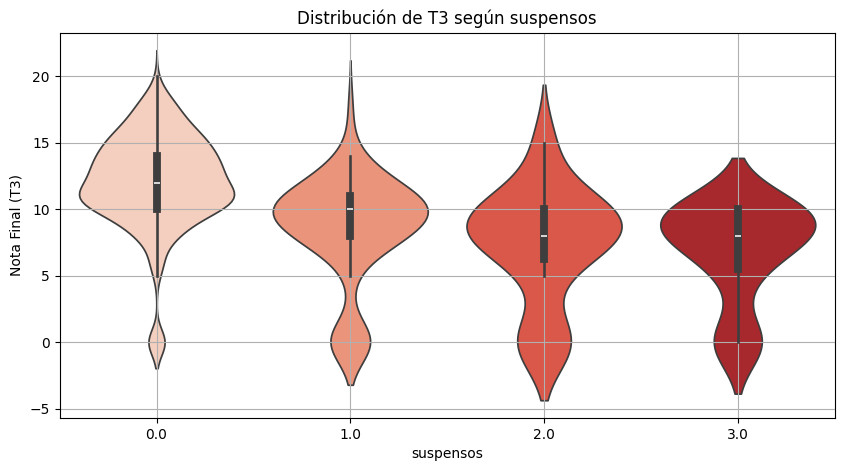

In [48]:
#para poder visualizar correctamente las relaciones y poder sacar conclusiones válidas, se agrupan el número de faltas por grupos.
if 'faltas' in train.columns and 'suspensos' in train.columns:
    train['Grupo_Faltas'] = pd.cut(train['faltas'], bins=[-1, 0, 5, 10, 20, np.inf], labels=["0", "1-5", "6-10", "11-20", "+20"])

    plt.figure(figsize=(10, 5))
    sns.violinplot(data=train, x='Grupo_Faltas', y='T3', inner='box', palette='Blues')
    plt.title('Distribución de T3 según grupos de faltas')
    plt.xlabel('Rango de faltas')
    plt.ylabel('Nota Final (T3)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.violinplot(data=train, x='suspensos', y='T3', inner='box', palette='Reds')
    plt.title('Distribución de T3 según suspensos')
    plt.xlabel('suspensos')
    plt.ylabel('Nota Final (T3)')
    plt.grid(True)
    plt.show()

In [49]:
#faltas

#Como se puede apreciar en los violinplots, aquellos estudiantes con más de 10 faltas tienden a tener peores calificaciones en T3
#Esto se puede ver de forma evidente con el valor de la mediana representado por un punto blanco. A pesar de los outliers (sorprendentes a mi parecer) parece
#una conclusión evidente y válida.

#suspensos

#en los violinplots mostrados en colores rojizos se pueden apreciar como cuando el número de suspensos es mayor que 0 las notas bajan. Se puede intuir además,
#que el numero de suspensos es inversamente proporcional con la nota final, ya que a más suspensos menos nota. Esto se puede visualizar de forma evidente de la misma forma
#que antes, es decir, con la mediana.

In [50]:
#Soluciones

#faltas
 
#Por tanto, una solución que podría frenar y bajar el índice de notas bajas por número alto de faltas es poner un sistema de 
#asistencia más duro. Se puede proponer un porcentaje de clases obligatorias a las que ir o un número mínimo de asistencia a clases para poder presentarse a la convocatoria
#final de la asignatura.

#suspensos

#Como solución se puede proponer un sistema de apoyo típico de centros escolares en los que aquellos alumnos con asignaturas suspensas tengan
#clases de refuerzo o ayuda de profesores particulares adjudicados. Clases obligatorias en horario no lectivo puede incentivar a dichos alumnos a estudiar más y reducir el número de suspensos.


5. Exploración adicional

In [51]:
#Para explorar más a fondo estos datos se aplican como técnicas de aprendizaje no supervisado PCA y Kmeans ya que PCA
#es útil para reducir la dimensionalidad y obtener efectividad y simplicidad al mismo tiempo. Además, esta técncia es 
#de gran utilidad para representar resultados en contextos académicos. También se emplea KMeans para agrupar los estudiantes
#en clusters con características simples y obtener patrones ocultos.

In [52]:
#antes de aplicar dichas técncias se estandarizan los datos para poder manejar datos con media 0 y desviación estándar 1, proceso imprescindible para PCA.
scaler = StandardScaler()
X_clustering = train_encoded.drop(columns=['T1', 'T2'], errors='ignore')
X_cluster_estandarizada = scaler.fit_transform(X_clustering)
print("Matriz escalada para PCA:")
print(pd.DataFrame(X_cluster_estandarizada).head())

Matriz escalada para PCA:
         0         1         2         3         4         5         6   \
0  1.804131 -0.575006 -1.329531  0.673540 -1.164407  3.996291  0.101429   
1  1.000263  1.247919  1.475233 -0.732475  0.052229  1.053696 -2.024567   
2 -0.607474  1.247919  1.475233 -0.732475  0.052229 -0.417602 -2.024567   
3 -0.607474  1.247919  0.540312  2.079555  0.052229 -0.417602  1.164426   
4  1.000263  0.336456  0.540312 -0.732475  0.052229  1.053696 -0.961569   

         7         8         9   ...        31        32        33        34  \
0  0.775384 -0.115912 -0.547748  ... -0.539047 -0.362541 -1.278307 -0.509340   
1  0.775384  0.756042 -0.547748  ...  1.855125  2.758305  0.782285 -0.509340   
2  0.775384  0.756042  0.550367  ... -0.539047 -0.362541  0.782285 -0.509340   
3  0.775384 -0.115912 -0.547748  ... -0.539047 -0.362541  0.782285 -0.509340   
4 -1.165983  0.756042  0.550367  ...  1.855125 -0.362541  0.782285  1.963327   

         35        36        37        38 

In [53]:
#ahora, para elegir el número correcto de clusters se muestran los dos métodos que concocemos por la teoría: método del codo y de la silueta.
#se muestran ambas gráficas.

C:\Users\alvar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\alvar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^

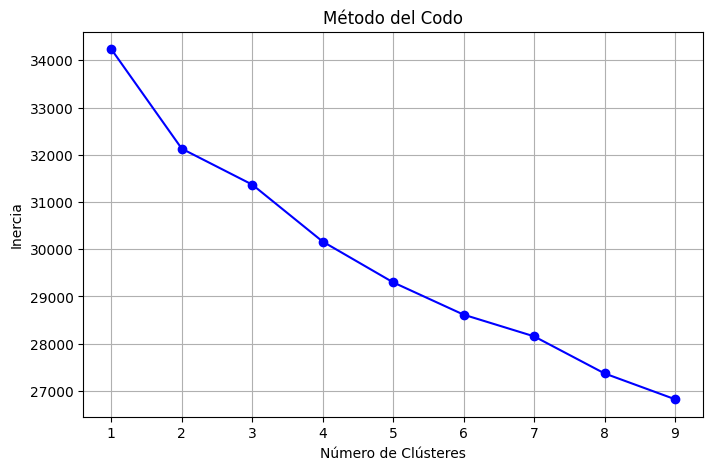

In [54]:
inercia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_estandarizada)
    inercia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inercia, 'bo-')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

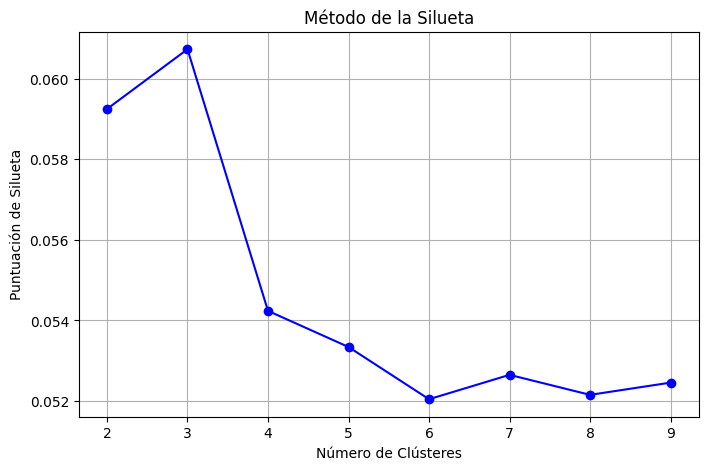

In [55]:
puntuacion_siluetas = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    etiquetas = kmeans.fit_predict(X_cluster_estandarizada)
    score = silhouette_score(X_cluster_estandarizada, etiquetas)
    puntuacion_siluetas.append(score)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), puntuacion_siluetas, 'bo-')
plt.xlabel('Número de Clústeres')
plt.ylabel('Puntuación de Silueta')
plt.title('Método de la Silueta')
plt.grid(True)
plt.show()

In [56]:
#como se pueden ver en el método del codo y de la silueta el valor óptimo de clusters es 3. En el método del codo se puede intuir que es 3 ya que es el valor a partir del cual la inercia
#deja de disminuir significativamente al aumentar el número de clústeres. Sin embargo, en el método de la silueta se puede ver que es 3 de forma muy clara ya que es el valor en el que
#se maximiza la puntuación de la silueta.

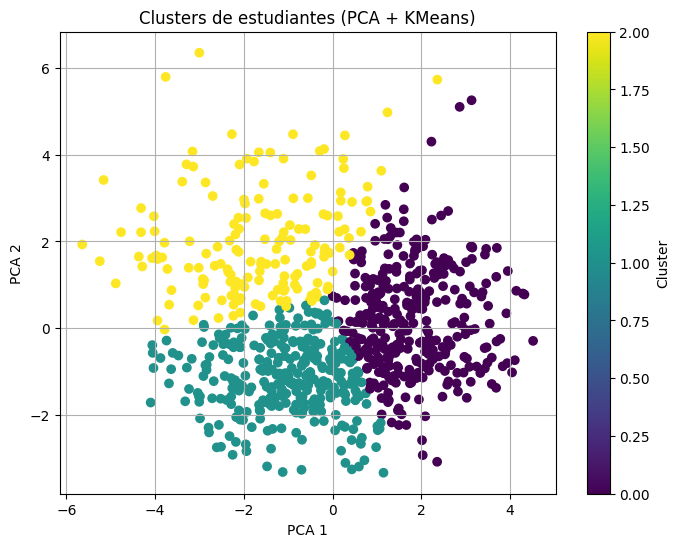

In [57]:
#se aplican las técnicas de aprendizaje no supervisado con valores inicializados a: 2 componentes en PCA (se explica ahora) y 3 clusters en KMeans(como ha quedado demostrado). 
# En este caso, se utilizan 2 componentes principales de PCA para reducir la dimensionalidad de los datos a un espacio bidimensional, lo que facilita su visualización
# y retiene la mayor parte de la varianza.

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_estandarizada)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title('Clusters de estudiantes (PCA + KMeans)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [58]:
#La gráfica de clusters de estudiantes, obtenida mediante PCA y KMeans, revela tres grupos distintos con características similares. 
# Estos clusters pueden ayudar a identificar patrones comunes en el rendimiento académico y permitir intervenciones personalizadas, como tutorías o apoyo (soluciones ya propuestas anteriormente).
# Además, facilitan la evaluación de estrategias educativas y la identificación temprana de estudiantes en riesgo, enriqueciendo el análisis y mejorando la toma de decisiones para optimizar el rendimiento
# de los estudiantes.

6. Predicciones

In [59]:
test_encoded = pd.get_dummies(test, drop_first=True)#test es el archivo csv cargado en la segunda celda del archivo

for columna in X.columns:
    if columna not in test_encoded.columns:
        test_encoded[columna] = 0

test_encoded = test_encoded[X.columns]

#se estandariza como se hizo para PCA
scaler = StandardScaler()
test_scaled_i = scaler.fit_transform(test_encoded)
test_scaled_ii = scaler.fit_transform(test_encoded.drop(columns=['T1', 'T2'], errors='ignore'))

predicciones_modelo1 = modelo_i.predict(test_scaled_i)
predicciones_modelo2 = modelo_ii_opt.predict(test_scaled_ii)

submission = pd.DataFrame({
    'Modelo_i': predicciones_modelo1,
    'Modelo_ii': predicciones_modelo2
})

submission.to_csv('predicciones_finales.csv', index=False)

C:\Users\alvar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\alvar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [60]:
#se comprueba que se haya generado el archivo csv con las predicciones finales de ambos modelos
final = pd.read_csv("predicciones_finales.csv")
print(final)

     Modelo_i  Modelo_ii
0        2.53   8.049882
1        0.97   9.987270
2        2.79  10.055752
3        2.47  10.418124
4        1.01   9.083016
..        ...        ...
204      6.04   9.046369
205      2.52   9.629793
206      5.28   9.703392
207      4.89  11.074879
208      3.18   9.934303

[209 rows x 2 columns]
